In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# run only once
!pip install statannotations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
# from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

# from ipynb.fs.full.All_Functions import GetPopParams
# from ipynb.fs.full.All_Functions import GetPopParamsOmega
# from ipynb.fs.full.All_Functions import GetVLIndParams
# from ipynb.fs.full.All_Functions import RandVLIndParams
# from ipynb.fs.full.All_Functions import RandVLParams
#from ipynb.fs.full.All_Functions import PKPDParams
# from ipynb.fs.full.All_Functions import Cohort_Prep
# from ipynb.fs.full.All_Functions import VLModel
# from ipynb.fs.full.All_Functions import VLPKPD
# from ipynb.fs.full.All_Functions import PK_Model
# from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
# from ipynb.fs.full.All_Functions import SimulateTreatment
# from ipynb.fs.full.All_Functions import Trial_Simulation

# from ipynb.fs.full.All_Functions import SimulateTreatmentPK
# from ipynb.fs.full.All_Functions import TreatmentImpact
# from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Required data:


- individual parameters from viral dynamics model
- dosage groups parameters from PK model
- parameters from PD model



Simulate one person without treatment (natural course of infection)
- read in viral dynamics parameters: rates of movement between different cell statuses
- set initial values of state variables: number of infected cells, number of cells in eclipse phase, number of cells in refractory phase, etc.
- function to solve viral dynamics set of differential equations: encode the differential equations (take in a set of 5 state variables and parameter values) and calculate the derivative of the system
- function to integrate differential equations: feed derivatives into numerical integrator function provided by python (scipy.integrate.odeint(func=derivative function, y0 = vector of initial values, t = timespan of integration, args = parameters), returns a vector of all 5 state variables for each time point in t)
- plot it

(incubation period is typically used when modeling intervention)
- time of symptoms is reference point for when treatment has started
- in real-life we don't now when infection started, but we do know when symptoms started

In [ ]:
Data_df=pd.read_csv('gdrive/My Drive/Leave/SchifferLab/EnsitrelvirModel/NBA_1510infections_7BroadVariants.csv')

# filtering data for a collection of people with omicron who have symptoms
Data_Omicron_symp = Data_df[(Data_df.cat_Lineage7variants=='Omicron')*(Data_df.cat_SympEver!='No')]
IDs_Symp = Data_Omicron_symp.ID.unique()
print(len(IDs_Symp))

# individual viral dynamics model data
parameters_df = pd.read_csv('gdrive/My Drive/Leave/SchifferLab/EnsitrelvirModel/estimatedIndividualParameters.txt')

# dosage group parameters for PK model
Popparameters_PK = pd.read_csv('gdrive/My Drive/Leave/SchifferLab/EnsitrelvirModel/PK_Params/estimatedIndividualParameters.txt')

822


Examine parameters of viral dynamics model

In [ ]:
parameters_df
# should I use the log

,id,log10beta_SAEM,log10pi_SAEM,log10rho_SAEM,log10phi_SAEM,delta_SAEM,m_SAEM,tau_SAEM,tzero_SAEM,Vzero_SAEM,...,cat_CumulativeExposure,cat_EarlyDetection,cat_EliminationConfirmed,cat_LineageBroad,cat_Rebound,cat_SympEver,cat_TiterGroup,cat_VaccStatus,tCat_LineageBroad,tCat_VaccStatus
0,460_1,-7.31875,2.45165,-2.576580,-5.20848,0.868359,18.1062,21.79380,1.63445,97,...,1,1,1,Other,0,Unknown,unknown,Unvaccinated,G_Delta_Other,G_First dose_No record_Unvaccinated
1,460_2,-7.31099,2.55443,-2.043930,-4.90595,2.397100,19.1514,10.50520,2.56223,97,...,5,0,1,Omicron,0,No,unknown,Boosted,G_Omicron,G_Boosted_Second dose
2,407_1,-7.29635,2.78213,-0.997934,-4.72413,1.313690,26.9115,7.24373,2.17267,97,...,4,0,1,Omicron,0,Yes,unknown,Boosted,G_Omicron,G_Boosted_Second dose
3,668_1,-7.28964,2.73563,-2.452880,-4.43043,0.833554,18.7802,28.26140,1.11970,97,...,1,1,1,Other,0,Unknown,unknown,Unvaccinated,G_Delta_Other,G_First dose_No record_Unvaccinated
4,240_1,-7.30339,2.82971,-1.458120,-6.45584,1.461070,21.2280,13.97710,1.57514,97,...,1,1,1,Other,0,Unknown,unknown,Unvaccinated,G_Delta_Other,G_First dose_No record_Unvaccinated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1543_1,-7.29995,2.70058,-1.621200,-5.97279,1.207840,19.2919,12.85950,2.46045,97,...,1,0,0,Omicron,0,Unknown,unknown,No record,G_Omicron,G_First dose_No record_Unvaccinated
1506,1665_1,-7.31645,2.38983,-1.298340,-4.90066,1.156750,18.9766,11.66930,1.69940,97,...,1,0,0,Omicron,0,Unknown,unknown,No record,G_Omicron,G_First dose_No record_Unvaccinated
1507,775_1,-7.31012,2.62145,-0.640266,-3.04519,1.096060,22.5556,9.66517,2.80300,97,...,1,0,0,NaN,0,Unknown,unknown,No record,G_None,G_First dose_No record_Unvaccinated
1508,1384_1,-7.29976,3.16905,-1.483350,-6.00778,1.619340,17.9647,11.97590,2.51835,97,...,1,0,0,Omicron,0,Unknown,unknown,No record,G_Omicron,G_First dose_No record_Unvaccinated


PK dataframe: id is a string

In [ ]:
Popparameters_PK

,id,ka_SAEM,kLP_SAEM,kCl_SAEM,kPL_SAEM,Vol_SAEM,ka_mean,kLP_mean,kCl_mean,kPL_mean,...,kLP_mode,kCl_mode,kPL_mode,Vol_mode,ka_sd,kLP_sd,kCl_sd,kPL_sd,Vol_sd,Geneder
0,250,46.7250,0.201178,0.243061,0.079162,20386.7,46.5798,0.175638,0.239723,0.078895,...,0.246619,0.253826,0.078751,20260.7,5.86392,0.101565,0.017957,0.008660,576.358,male
1,375,15.9460,34.943200,0.294573,0.079114,20702.7,15.7973,50.314700,0.314324,0.078638,...,1.159250,0.344893,0.079348,20235.5,1.37779,894.997000,0.037992,0.010019,750.176,female
2,500,52.1547,0.082352,0.293589,0.079306,16889.1,51.2426,0.074350,0.290781,0.080113,...,0.055463,0.287481,0.079626,16957.8,6.86386,0.043740,0.020805,0.009378,587.738,male
3,1000,40.7201,0.370172,0.348508,0.082136,17587.6,40.5313,0.371485,0.351140,0.080346,...,0.383996,0.355036,0.080956,17514.3,5.01825,0.102840,0.016990,0.009486,552.617,male
4,2000,23.4626,0.015860,0.263757,0.078635,21107.3,23.4123,0.012890,0.266050,0.078584,...,0.012964,0.268649,0.078356,20981.3,2.45330,0.004975,0.015286,0.009146,733.413,male
5,375-125 M,47.4108,31.205000,0.258423,0.077545,15295.5,47.0687,23.335100,0.262267,0.078255,...,0.239565,0.267696,0.078518,15194.8,6.04190,305.459000,0.032363,0.009634,503.135,male
6,750-250 M,48.4785,683.341000,0.188692,0.077724,18416.4,47.9057,257.014000,0.187068,0.078934,...,1.952340,0.188259,0.078300,18352.2,6.37974,5086.860000,0.016839,0.009586,557.637,male
7,750-250 F,12.9665,67.790900,0.250608,0.076699,18812.7,12.7606,171.578000,0.258854,0.077920,...,0.002449,0.229615,0.076369,18676.3,1.07339,2257.160000,0.037919,0.009628,649.162,female
8,375-125 F,15.1249,59.197100,0.278075,0.077134,16913.0,14.9022,224.317000,0.276658,0.078006,...,0.001256,0.255417,0.077607,16792.0,1.60404,4430.220000,0.036483,0.009204,584.174,female


Change in viral load from trial:
- placebo
- 250 group

Use this data to fit our clinical trial simulation model once we are testing with a large group of people

([<matplotlib.axis.XTick at 0x7f3de1f492a0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(9, 0, '9'),
  Text(14, 0, '14'),
  Text(21, 0, '21')])

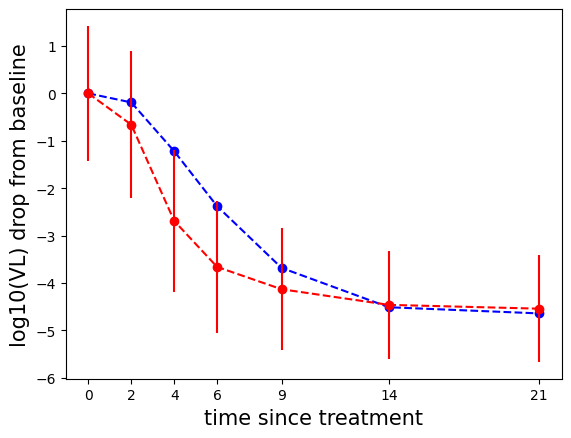

In [ ]:
Trial_Data_Times = [0, 2, 4, 6, 9, 14, 21]
Trial_Data_Placebo = [6.94, 6.75, 5.72, 4.56, 3.26, 2.43, 2.3]
# Trial_Data_Placebo_SD = []
Trial_Data_250 = [6.90, 6.24, 4.21, 3.24, 2.77, 2.44, 2.36]
Trail_Data_250_SD = [1.422750063, 1.553007131, 1.492605185, 1.394585388, 1.288354977, 1.141439311, 1.122988801]

Trial_VLdrop_Placebo = np.asarray(Trial_Data_Placebo)-Trial_Data_Placebo[0]
Trial_VLdrop_250 = np.asarray(Trial_Data_250)-Trial_Data_250[0]

plt.plot(Trial_Data_Times, Trial_VLdrop_Placebo, '--o', color = 'b')
# plt.plot(Trial_Data_Times, Trial_VLdrop_250, '--o', color = 'r')
plt.errorbar(Trial_Data_Times, Trial_VLdrop_250, Trail_Data_250_SD, fmt='--o', color = 'r')
plt.xlabel('time since treatment', fontsize = 15)
plt.ylabel('log10(VL) drop from baseline', fontsize = 15)
plt.xticks([0,2,4,6,9,14,21])

Randomly sample 400 ID (people) from NBA cohort

Establish functions

In [ ]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    '''
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    # uses ID to look at specific row of dataframe of parameters
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [ ]:
# dosage id should be in string
PK_params = GetVLIndParams(Popparameters_PK, '250', style = 'mode')
PK_params

{'ka': 44.7714,
 'kLP': 0.246619,
 'kCl': 0.253826,
 'kPL': 0.0787513,
 'Vol': 20260.7}

In [ ]:
def PKPDParams(Popparameters, GetVLIndParams, Emax, IC50, Hill, dose, PDOm):
    # subfunction called by ParamsPrep
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetVLIndParams(Popparameters, dose, style= 'mode')
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    return dict(zip(param_Order, PKPDparams))

In [ ]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, Emax, IC50, Hill,PDOm, dose):
  #  remove Popparameters_df because CohortStyle will always be direct
  # ID's of all 400 individuals are taken into this function
  # will add the PK/PD parameters for all 40 individuals

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        # else:
            # ind_params = RandVLParams(Popparameters_df, param_dist)

        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetVLIndParams, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [ ]:
# specifying the arguments to feed into ParamsPrep as the parameters that we want

# order of parameters to feed into model function
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']

# non-estimated parameters
fixed_params = dict({'c': 15, 'r':10, 'k':4})

# don't need it for this one because we are not drawing from a distribution
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal',
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal',
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

# information about incubation period for each variant
# we only have omicron in this simulation
Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']

# these are the parameters for the incubation period for different variants

# Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
# SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

# try varying the mean for omicron (second to last element)
# trials: 3.5, 2.6 for omicron
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 2.6, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.0, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

,Mean
0,4.61


In [ ]:
# Ensitrelvir in vitro IC50
# PD parameters

Emax = 1.00
IC50 = 0.27180023
Hill = 2.30448547
# standard errors of above coefficients
PDOm = 0.02169204, 0.02168920, 0.36160564
MolMass = 531.88  # g/Mol

In [ ]:
PKPDParams(Popparameters_PK, GetVLIndParams, Emax, IC50, Hill, '250', PDOm)

{'ka': 44.7714,
 'k12': 0.0787513,
 'k21': 0.246619,
 'kcl': 0.253826,
 'Vol': 20260.7,
 'Emax': 1.0,
 'IC50': 0.27180023,
 'Hill': 2.30448547}

Set initial state variable conditions of cell statuses

In [ ]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0
    E_0 = 0
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

Viral load model: how the cells are moving between different states

In [ ]:
def VLModel(y, t, beta, phi, rho, k, delta, m, pi, c,tAI):
  # remove the h
    '''Natural History model'''
    T,R,E,I,V = y

    if t > tAI:
        eps = m
    else:
        eps = 0

    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    # just delta*I
    ddt_I = k*E - delta*I - eps*I
    if I>=1:
        ddt_V = pi*I-c*V
    else:
        ddt_V = -c*V
    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

Simulate viral history

In [ ]:
def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, loading_dose, dosetimes, PotRed, MolMass):
    # PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = PKPDInd['Hill']
    # modify IC50 by PotRed, which we are estimating
    # PotRed is passed into function
    IC50 = PotRed*PKPDInd['IC50']

    # PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)

    # randomly selected start of treatment
    # if start of treatment is at tzero: we enter
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            if j==0:
                init[5] = init[5] + loading_dose
            else:
                init[5] = init[5] + dose
            # integrating until the time that you give the next dose, which is ttemp
            # times into arange can be a non-integer float, but double-check that everything is numerically consistent
            # maybe use np.linspace?
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
    else:
        # otherwise, we simulated from the first time that we give the dose if treatment doesn't start at begining of infection

        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)

        ytemp = y.copy()

        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            if j==0:
                init[5] = init[5] + loading_dose
            else:
                init[5] = init[5] + dose
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)

            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)

    #simulate until tend
    init = ytemp[-1,:].T
    init[5] = init[5] + dose
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)
    return t, y

In [ ]:
def Trial_Simulation_paramInput(TrtmntStrtDay, params,
                                PKPDInd, param_dict, PotRed, MolMass, dose, loading_dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 1):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset.
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])

        # dosetimes will now be an array of float values
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes)
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, loading_dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [ ]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params,
                        PKPDInd, param_dict, PotRed, MolMass, dose, loading_dose, LOD, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 1):

    # minimum incubation period ~1 day
    # min_incub = 1

    # randomly assign start of symptom onset
    # PotRed is a vector of length N (size of cohort)
    # adjust tzero and tau: tau is timing of immune response, tzero is start of simulation which coincides with start of symptom onset
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                # we are using this section bc we know the variants
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)
            # shift the gamma distribution by minimum incubation period
            # incub = min_incub + np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:],
                                                          PKPDInd[idi], param_dict[idi],
                                                          PotRed[idi], MolMass, 0, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**LOD))
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == LOD) & (t>Tmax))]

            while (len(PS_Duration) != 0 and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:],
                                                          PKPDInd[idi], param_dict[idi],
                                                          PotRed[idi], MolMass, 0, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**LOD))
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == LOD) & (t>Tmax))]

    return params, param_dict

In [ ]:
def Cohort_Prep(IDs, Num):
    Cohort = random.choices(IDs, k=Num)
    return np.asarray(Cohort)

In [ ]:
# we don't need this function
# randomly assign individual parameters based on distribution
# however, we are directly taking estimated parameters
def RandVLParams(Popparameters, param_dist):

    cols = list(Popparameters.parameter)

    pid_params = Popparameters

    omega = []
    values = []
    keys = []
    for i, c in enumerate(cols):
        if 'pop' in c:
            k = c.split('_')[0]
            keys.append(k)
         #   print(keys)
            v = pid_params.value[i]
            values.append(v)
        if 'omega' in c:
            om = pid_params.value[i]
            omega.append(om)
         #   print(values)
    eta = np.random.normal(np.zeros(len(omega)), omega, len(omega))

    for i,(v,k) in enumerate(zip(values, keys)):
        if param_dist[k]=='logNormal':
            values[i] = v*np.exp(eta[i])
        elif 'log10' in k:
            values[i]=v+eta[i]
            values[i] = 10**values[i]
            keys[i] = k.split('0')[1]
        else:
            minn = param_dist[k+'min']
            maxx = param_dist[k+'max']
            v = np.log((v-minn)/(maxx-v)) + eta[i]
            values[i] = (maxx*np.exp(v)+minn)/(1+np.exp(v))

    params = dict(zip(keys, values))
    return params

In [ ]:
# Write function for model simulation
def VLPKPD(y, t, beta, phi, rho, k, delta, m, pi, c,tAI, ka, k12, kcl, k21,Vol, MolMass,E_max, IC50, Hill_Coeff):
  # there is no h parameter
  # tAI is TAU

    T,R,E,I,V,Ag, A1, A2 = y

    # PK model
    dAg = -ka*Ag
    dA1 = ka*Ag+k21*A2-(kcl+k12)*A1
    dA2 = k12*A1-k21*A2

    # PD model
    conc = A1*10**6/Vol/MolMass # # convert to from nanogram/mL to micromolar
    epsN = np.divide(np.multiply(E_max,np.power(conc,Hill_Coeff)),(np.power(IC50, Hill_Coeff)+np.power(conc,Hill_Coeff)))

    # within-host treatment model
    # tAI: AI stands for adaptive immune response
    if t > tAI:
        m_AI = m
    else:
        m_AI = 0

    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*I - m_AI*I
    if I>=1:
        ddt_V = (1-epsN)*pi*I-c*V
    else:
        ddt_V = -c*V

    return  ddt_T, ddt_R, ddt_E, ddt_I, ddt_V, dAg, dA1, dA2

Control arm simulation

In [ ]:
dose = 0
loading_dose = 0
Num = 400
Mean_drop_VL_TotPop_cntrl_runs = []
drop_VL_runs = []
R2_run=[]
VL_run = []
LOD = 2.08
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})

# potency reduction factor should be a vector of size of cohort
# starting with prf = 1
PotRed=np.ones(Num)

# change to run 10 x
for run in range(0,1):
    print(run)
    Mean_drop_VL_TotPop_cntrl=[]
    drop_VL=[]
    VL =[]
    # Cohort = Cohort_Prep(IDs_Symp, Num)
    # change cohort to be a list instead of an array
    Cohort_F = Cohort_Prep(IDs_Symp, (Num // 2))
    Cohort_M = Cohort_Prep(IDs_Symp, (Num // 2))

    # randomly selects treatment days from either day 1 or day 2
    # TreatmntStrtDay = random.choices(range(1,3), k=Num)

    # ramdonly select treatment days (floats) from between day 1 to day 2
    TreatmntStrtDay = []
    for i in range(0, Num):
      # this returns a random float
      x = random.uniform(0.5, 2.5)
      TreatmntStrtDay.append(x)

    # randomly selects treatment days from either day 1, day 2, or day 3
    # TreatmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)

    # VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams,
                                                # parameters_df, fixed_params,
                                                # param_order, param_dist, PKPDParams,
                                                # Popparameters_PK, Emax,
                                                # IC50, Hill,PDOm, '250')
    VLInd_F, PKPD_Params_F, param_dict_F = ParamsPrep(Cohort_F, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '375-125 F')
    VLInd_M, PKPD_Params_M, param_dict_M = ParamsPrep(Cohort_M, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '375-125 M')
    # merge M and F together
    # join lists
    VLInd = VLInd_F + VLInd_M
    PKPD_Params = PKPD_Params_F + PKPD_Params_M
    param_dict = param_dict_F + param_dict_M
    # join arrays
    Cohort = np.concatenate((Cohort_F, Cohort_M), axis=0)

    # still need incubation prep when simulating control arm
    VLInd, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd,
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, loading_dose, LOD, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 1)

    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi],
                                                         PotRed[idi], MolMass, dose, loading_dose, SetInit, VLPKPD,
                                                     TreatmentLength = 5, TreatmentFrequency = 1)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))

        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+22)[0][0]
        drop_VL.append(X[tstart:tend]-X[tstart])
        VL.append(X[tstart:tend])

    # Check for inconsistent array lengths within drop_VL
    lengths = [len(arr) for arr in drop_VL]

    # hard coded the reference length
    ref_length = 22000

    for k in range(len(lengths)):
        if lengths[k] != ref_length:
          # replace the array with an array without the last extra entry
          # this is a temporary solution
          drop_VL[k] = drop_VL[k][:-1]

    Mean_drop_VL_TotPop_cntrl=np.mean(drop_VL, axis=0)
    # getting the first index of the entry at the timepoint where it is true
    t2 = np.argwhere(np.linspace(0, 21.999, 22000)>=2)[0][0]
    t4 = np.argwhere(np.linspace(0, 21.999, 22000)>=4)[0][0]
    t6 = np.argwhere(np.linspace(0, 21.999, 22000)>=6)[0][0]
    t9 = np.argwhere(np.linspace(0, 21.999, 22000)>=9)[0][0]
    t14 = np.argwhere(np.linspace(0, 21.999, 22000)>=14)[0][0]
    t21 = np.argwhere(np.linspace(0, 21.999, 22000)>=21)[0][0]

    # feed indices into vector of mean drop in viral load
    r2 = r2_score(Trial_VLdrop_Placebo,
              [Mean_drop_VL_TotPop_cntrl[0], Mean_drop_VL_TotPop_cntrl[t2], Mean_drop_VL_TotPop_cntrl[t4],
               Mean_drop_VL_TotPop_cntrl[t6],Mean_drop_VL_TotPop_cntrl[t9], Mean_drop_VL_TotPop_cntrl[t14],
               Mean_drop_VL_TotPop_cntrl[t21]])

    VL_run.append(VL)
    drop_VL_runs.append(drop_VL)
    Mean_drop_VL_TotPop_cntrl_runs.append(Mean_drop_VL_TotPop_cntrl)
    R2_run.append(r2)


0


<Figure size 800x500 with 0 Axes>

In [ ]:
print(np.round(R2_run,2))
st.mode(np.round(R2_run,2))

[0.97]


ModeResult(mode=0.97, count=1)

0


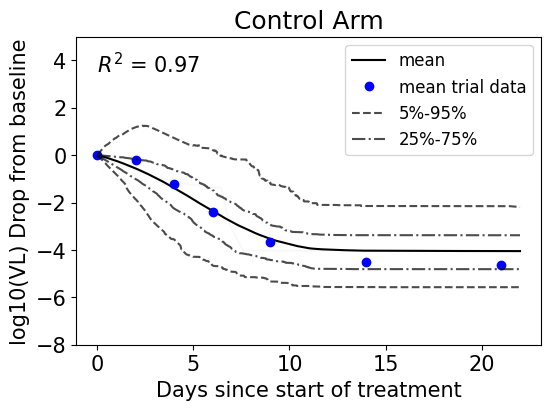

In [ ]:
fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})
i= np.argwhere(np.round(R2_run,2) ==st.mode(np.round(R2_run,2)).mode)[0][0]
print(i)
# change the loop to iterate only once instead of 400 times because we only have 1 person in simulation
# ASK: should i change loop to go Num times?
for idi in range(0,1):
    plt.plot(np.linspace(0, 21.999, 22000),drop_VL_runs[i][idi], color = 'grey', alpha = 0.05)

perc_5 = np.percentile(drop_VL_runs[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 21.999, 22000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 21.999, 100000))
perc_95 = np.percentile(drop_VL_runs[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 21.999, 22000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 21.999, 100000))
perc_25 = np.percentile(drop_VL_runs[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 21.999, 22000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 21.999, 100000))
perc_75 = np.percentile(drop_VL_runs[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 21.999, 22000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 21.999, 100000))
t2 = np.argwhere(np.linspace(0, 21.999, 22000)>=2)[0][0]
t4 = np.argwhere(np.linspace(0, 21.999, 22000)>=4)[0][0]
t6 = np.argwhere(np.linspace(0, 21.999, 22000)>=6)[0][0]
t9 = np.argwhere(np.linspace(0, 21.999, 22000)>=9)[0][0]
t14 = np.argwhere(np.linspace(0, 21.999, 22000)>=14)[0][0]
t21 = np.argwhere(np.linspace(0, 21.999, 22000)>=21)[0][0]



plt.plot(np.linspace(0, 21.999, 22000), Mean_drop_VL_TotPop_cntrl_runs[i], color = 'k', label = 'mean')
plt.plot(Trial_Data_Times, Trial_VLdrop_Placebo,'o', color = 'b', label = 'mean trial data')

plt.plot(np.linspace(0, 21.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
plt.plot(np.linspace(0, 21.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
plt.plot(np.linspace(0, 21.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
plt.plot(np.linspace(0, 21.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)
plt.text(0,3.5,'$R^2$ = ' + str(round(R2_run[i],2)))
plt.xlabel('Days since start of treatment')
plt.ylabel('log10(VL) Drop from baseline')
plt.ylim([-8, 5])
plt.title('Control Arm')
plt.legend(fontsize = '12')

Research question: How many people do you need before it starts to fit the data well?

Simulate treatment with 375 / 125 mg AND 750 /250 MG of ensitrelvir

In [ ]:
n=0
LOD = 2.08
fig = plt.figure(figsize = (20,15))
plt.rcParams.update({'font.size': 25})
prf = []
Num= 400
R2 = []

# run only once for now for faster runtime
# for run in np.arange(0,10):
for run in np.arange(0, 1):
    print(run)
# -------- Running the treatment arm ----------
    dose = 250
    loading_dose = 750
    PotRed = np.ones(Num)

    r2 = []
    # Cohort = Cohort_Prep(IDs_Symp, Num)
    Cohort_F = Cohort_Prep(IDs_Symp, (Num // 2))
    Cohort_M = Cohort_Prep(IDs_Symp, (Num // 2))

    # TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
    # I can probably just set TreatmntStrtDay once where k=Num
    # TreatmntStrtDay_F = random.choices(range(1,3), k=len(Cohort_F))
    # TreatmntStrtDay_M = random.choices(range(1,3), k=len(Cohort_M))

    TreatmntStrtDay = []
    for i in range(0, Num):
      # this returns a random float
      x = random.uniform(0.5, 2.5)
      TreatmntStrtDay.append(x)

    # debugging: check the first few entries of TreatmntStrtDay
    # for m in range(0, 20):
        # print("m: ", m, "treatment start day: ", TreatmntStrtDay[m])

    # VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams,
                                                # parameters_df, fixed_params,
                                                # param_order, param_dist, PKPDParams,
                                                # Popparameters_PK, Emax,
                                                # IC50, Hill,PDOm, dose)
    VLInd_F, PKPD_Params_F, param_dict_F = ParamsPrep(Cohort_F, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '750-250 F')
    VLInd_M, PKPD_Params_M, param_dict_M = ParamsPrep(Cohort_M, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '750-250 M')

    # merge M and F together
    # join lists
    VLInd = VLInd_F + VLInd_M
    PKPD_Params = PKPD_Params_F + PKPD_Params_M
    param_dict = param_dict_F + param_dict_M
    # TreatmntStrtDay = TreatmntStrtDay_F + TreatmntStrtDay_M
    # join arrays
    Cohort = np.concatenate((Cohort_F, Cohort_M), axis=0)

    # PotRed isn't used to find incubation period
    VLInd, param_dict = Incubation_Prep(Data_Omicron_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd,
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, loading_dose, LOD, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 1)

    # goes through many different potential PotRed values over 1 selected cohort
    # select from 1 to 250 every 5, so it runs 50 x
    # change to try every 25th prf for faster run time
    # for PotRed in range(1,250, 5):
    for PotRed in range(1,250, 10):
        print("  " + str(PotRed))
        V = []
        drop_VL = []
        Mean_drop_VL_TotPop = []

        # iterate through everyone in the cohort
        for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):


            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi],
                                                         PotRed, MolMass, dose, loading_dose, SetInit, VLPKPD,
                                                         TreatmentLength = 5, TreatmentFrequency = 1)
            T,R,E,I,V, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V,10**LOD))
            tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
            tend = np.argwhere(t>=TrtmntStrtDay+22)[0][0]
            drop_VL.append(X[tstart:tend]-X[tstart])

        # Check for inconsistent array lengths within drop_VL
        lengths = [len(arr) for arr in drop_VL]

        # hard coded the reference length
        ref_length = 22000

        for k in range(len(lengths)):
            if lengths[k] != ref_length:
              # replace the array with an array without the last extra entry
              # this is a temporary solution
              drop_VL[k] = drop_VL[k][:-1]

        Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
        t2 = np.argwhere(np.linspace(0, 21.999, 22000)>=2)[0][0]
        t4 = np.argwhere(np.linspace(0, 21.999, 22000)>=4)[0][0]
        t6 = np.argwhere(np.linspace(0, 21.999, 22000)>=6)[0][0]
        t9 = np.argwhere(np.linspace(0, 21.999, 22000)>=9)[0][0]
        t14 = np.argwhere(np.linspace(0, 21.999, 22000)>=14)[0][0]
        t21 = np.argwhere(np.linspace(0, 21.999, 22000)>=21)[0][0]
        r2.append(r2_score(Trial_VLdrop_250,
              [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t2], Mean_drop_VL_TotPop[t4],
               Mean_drop_VL_TotPop[t6],Mean_drop_VL_TotPop[t9], Mean_drop_VL_TotPop[t14],
               Mean_drop_VL_TotPop[t21]]))

    R2.append(r2)

0
  1
  11
  21
  31
  41
  51
  61
  71
  81
  91
  101
  111
  121
  131
  141
  151
  161
  171
  181
  191
  201
  211
  221
  231
  241


<Figure size 2000x1500 with 0 Axes>

181.0


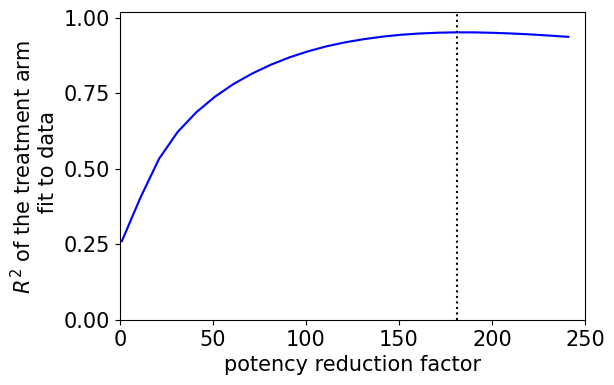

In [ ]:
fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})

prf=[]
# for run in np.arange(0,10):
for run in np.arange(0, 1):
    # plt.plot(range(1,250,5), R2[run], color= 'steelblue', alpha = 0.2)
    plt.plot(range(1,250,10), R2[run], color= 'steelblue', alpha = 0.2)

    prf_index= np.argwhere(R2[run]==max(R2[run]))
    # prf.append(range(1,250,5)[prf_index[0][0]])
    prf.append(range(1,250,10)[prf_index[0][0]])

R2_Ave=np.mean(R2, axis=0)
# plt.plot(range(1,250,5), R2_Ave, color= 'b', alpha = 1, label= 'All')
plt.plot(range(1,250,10), R2_Ave, color= 'b', alpha = 1, label= 'All')
plt.vlines(x = np.median(prf) , ymin = 0.0, ymax = 1.5, color = 'k', linestyle = 'dotted')
plt.ylim([0.0, 1.02])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.])
plt.xlim([0,250])
plt.ylabel('$R^2$ of the treatment arm \n fit to data')
plt.xlabel('potency reduction factor')
print(np.median(prf))

191.0


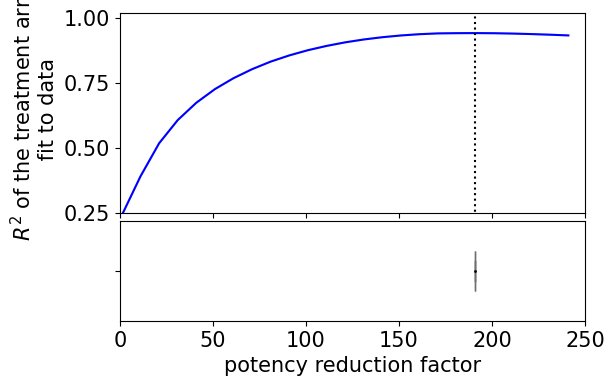

In [ ]:
# find the best prf that fits the data the best

fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})
gs = fig.add_gridspec(2, hspace=0.05, height_ratios= [2, 1])
axs = gs.subplots(sharex=True)
prf=[]
# for run in np.arange(0,10):
for run in np.arange(0, 1):
    # axs[0].plot(range(1,250,5), R2[run], color= 'steelblue', alpha = 0.2)
    axs[0].plot(range(1,250,10), R2[run], color= 'steelblue', alpha = 0.2)

    prf_index= np.argwhere(R2[run]==max(R2[run]))
    # prf.append(range(1,250,5)[prf_index[0][0]])
    prf.append(range(1,250,10)[prf_index[0][0]])

R2_Ave=np.mean(R2, axis=0)
# axs[0].plot(range(1,250,5), R2_Ave, color= 'b', alpha = 1, label= 'All')
axs[0].plot(range(1,250,10), R2_Ave, color= 'b', alpha = 1, label= 'All')
axs[0].vlines(x = np.median(prf) , ymin = 0.0, ymax = 1.5, color = 'k', linestyle = 'dotted')
axs[0].set_ylim([0.25, 1.02])
axs[0].set_yticks([0.25, 0.5, 0.75, 1.])
axs[0].set_xlim([0,250])
axs[0].set_ylabel('$R^2$ of the treatment arm \n fit to data')
sns.swarmplot(x=prf, color = 'k', size = 2, ax = axs[1])
sns.boxplot(x=prf, color = 'skyblue', saturation=0.5, width=0.4, ax = axs[1])

# ASK: what is the intention of the below lines? it seems that .text wants a scalar value for its second argument, but the operation returns a list
# new_axis_one = [x - 0.22 for x in axs[1].get_yticks()]
# axs[1].text(np.median(prf) + np.median(prf)*0.01, new_axis_one, np.median(prf),
            # horizontalalignment='center',size='medium',color='k')
axs[1].set_xlabel('potency reduction factor')
#axs[1].set_xticks(range(0,250,20))
print(np.median(prf))

# my first trial had an optimized prf of around 101

Shadi got a similar prf for the same treatment arm when only looking at male participants. This is bc kCL is similar btwn M and F, which has a larger effect on prf than kA.

In [ ]:
# simulate treatment arm once with the known best prf

dose = 250
loading_dose = 750
Num= 400
Mean_drop_VL_TotPop_runs = []
drop_VL_runs = []
R2_run=[]
VL_run = []
LOD = 2.08
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})

# PotRed=141
PotRed = 181

# run once for faster runtime while testing
# for run in range(0,10):
for run in range(0,1):
    print(run)
    Mean_drop_VL_TotPop=[]
    drop_VL=[]
    VL =[]

    # Cohort = Cohort_Prep(IDs_Symp, Num)
    Cohort_F = Cohort_Prep(IDs_Symp, (Num // 2))
    Cohort_M = Cohort_Prep(IDs_Symp, (Num // 2))
    # TreatmntStrtDay = random.choices(range(1,3), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 2)

    TreatmntStrtDay = []
    for i in range(0, Num):
      # this returns a random float
      x = random.uniform(0.5, 2.5)
      TreatmntStrtDay.append(x)

    # VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams,
                                                # parameters_df, fixed_params,
                                                # param_order, param_dist, PKPDParams,
                                                # Popparameters_PK, Emax,
                                                # IC50, Hill,PDOm, dose)
    VLInd_F, PKPD_Params_F, param_dict_F = ParamsPrep(Cohort_F, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '750-250 F')
    VLInd_M, PKPD_Params_M, param_dict_M = ParamsPrep(Cohort_M, 'direct', GetVLIndParams, RandVLParams,
                                                parameters_df, fixed_params,
                                                param_order, param_dist, PKPDParams,
                                                Popparameters_PK, Emax,
                                                IC50, Hill,PDOm, '750-250 M')

    # merge M and F together
    # join lists
    VLInd = VLInd_F + VLInd_M
    PKPD_Params = PKPD_Params_F + PKPD_Params_M
    param_dict = param_dict_F + param_dict_M
    # join arrays
    Cohort = np.concatenate((Cohort_F, Cohort_M), axis=0)

    # iterate through everyone in cohort
    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):


        if Data_Omicron_symp[Data_Omicron_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
            Lineage = 'Total'
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
        else:
            Lineage = Data_Omicron_symp[Data_Omicron_symp.ID==ID].cat_Lineage7variants.unique()[0]
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

        incub = np.random.gamma(shape, scale)

        VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
        param_dict[idi]['tzero']=incub[0]
        param_dict[idi]['tau']=VLInd[idi][-1]

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi],
                                                         PotRed, MolMass, dose, loading_dose, SetInit, VLPKPD,
                                                     TreatmentLength = 5, TreatmentFrequency = 1)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))

        Tmax_index = np.argwhere(X==max(X))[0][0]
        Tmax = t[Tmax_index]

        PS_Duration = t[np.where((X == 10**LOD) & (t>Tmax))]
        while (PS_Duration != [] and PS_Duration[0]<5):
            incub = np.random.gamma(shape, scale)

            VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=VLInd[idi][-1]

            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi],
                                                         PotRed, MolMass, dose, loading_dose, SetInit, VLPKPD,
                                                     TreatmentLength = 5, TreatmentFrequency = 1)
            T,R,E,I,V, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V,10**LOD))

            Tmax_index = np.argwhere(X==max(X))[0][0]
            Tmax = t[Tmax_index]
            PS_Duration = t[np.where((X == 10**LOD) & (t>Tmax))]

        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+22)[0][0]
        drop_VL.append(X[tstart:tend]-X[tstart])
        VL.append(X[tstart:tend])

    # Check for inconsistent array lengths within drop_VL
    lengths = [len(arr) for arr in drop_VL]

    # hard coded the reference length
    ref_length = 22000

    for k in range(len(lengths)):
        if lengths[k] != ref_length:
          # replace the array with an array without the last extra entry
          # this is a temporary solution
          drop_VL[k] = drop_VL[k][:-1]

    Mean_drop_VL_TotPop=np.mean(drop_VL, axis=0)
    t2 = np.argwhere(np.linspace(0, 21.999, 22000)>=2)[0][0]
    t4 = np.argwhere(np.linspace(0, 21.999, 22000)>=4)[0][0]
    t6 = np.argwhere(np.linspace(0, 21.999, 22000)>=6)[0][0]
    t9 = np.argwhere(np.linspace(0, 21.999, 22000)>=9)[0][0]
    t14 = np.argwhere(np.linspace(0, 21.999, 22000)>=14)[0][0]
    t21 = np.argwhere(np.linspace(0, 21.999, 22000)>=21)[0][0]
    r2 = r2_score(Trial_VLdrop_250,
              [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t2], Mean_drop_VL_TotPop[t4],
               Mean_drop_VL_TotPop[t6],Mean_drop_VL_TotPop[t9], Mean_drop_VL_TotPop[t14],
               Mean_drop_VL_TotPop[t21]])

    VL_run.append(VL)
    drop_VL_runs.append(drop_VL)
    Mean_drop_VL_TotPop_runs.append(Mean_drop_VL_TotPop)
    R2_run.append(r2)


0


<Figure size 800x500 with 0 Axes>

In [ ]:
np.round(R2_run,2)

array([0.94])

0


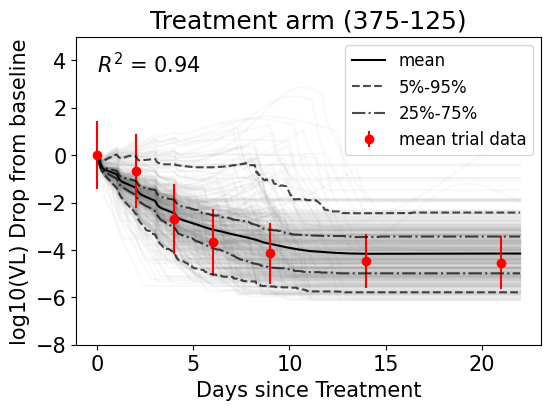

In [ ]:
fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})
# i changed i from 5 to 0 because i only ran 1 trial
# i= 5
i = 0
#np.argwhere(np.round(R2_run,2) ==st.mode(np.round(R2_run,2)).mode)[0][0]
print(i)
for idi in range(0,Num):
    plt.plot(np.linspace(0, 21.999, 22000),drop_VL_runs[i][idi], color = 'grey', alpha = 0.05)
perc_5 = np.percentile(drop_VL_runs[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 21.999, 22000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 21.999, 100000))
perc_95 = np.percentile(drop_VL_runs[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 21.999, 22000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 21.999, 100000))
perc_25 = np.percentile(drop_VL_runs[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 21.999, 22000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 21.999, 100000))
perc_75 = np.percentile(drop_VL_runs[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 21.999, 22000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 21.999, 100000))
t2 = np.argwhere(np.linspace(0, 21.999, 22000)>=2)[0][0]
t4 = np.argwhere(np.linspace(0, 21.999, 22000)>=4)[0][0]
t6 = np.argwhere(np.linspace(0, 21.999, 22000)>=6)[0][0]
t9 = np.argwhere(np.linspace(0, 21.999, 22000)>=9)[0][0]
t14 = np.argwhere(np.linspace(0, 21.999, 22000)>=14)[0][0]
t21 = np.argwhere(np.linspace(0, 21.999, 22000)>=21)[0][0]



plt.plot(np.linspace(0, 21.999, 22000), Mean_drop_VL_TotPop_runs[i], color = 'k', label = 'mean')
# plt.plot(Trial_Data_Times, Trial_VLdrop_250,'o', color = 'r', label = 'mean trial data')
# add error bars to trail data
plt.errorbar(Trial_Data_Times, Trial_VLdrop_250, Trail_Data_250_SD, fmt='o', color = 'r', label = 'mean trial data')

plt.plot(np.linspace(0, 21.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
plt.plot(np.linspace(0, 21.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
plt.plot(np.linspace(0, 21.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
plt.plot(np.linspace(0, 21.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)
plt.text(0,3.5,'$R^2$ = ' + str(round(R2_run[i],2)))

# are these axes labels correct?
plt.xlabel('Days since Treatment')
plt.ylabel('log10(VL) Drop from baseline')
plt.ylim([-8, 5])
#plt.title('control arm')
plt.title('Treatment arm (750-250)')
plt.legend(fontsize = '12')

Simulation estimates above mean trial data for both control and treatment arms. The fit we are getting to the data points that are captured throughout the treatment (days 0-5) is mostly determined by the prf, but the fit we are getting to the data points after the treatment are more sensitive to the trial design (limit of detection and trial enrollment date). We don't want to play with LoD because the assay stays the same. In the phase III trial, they divided cohort into 2: < 72 hrs, 72 <= time < 120 hrs. We might want to exclude ppl who showed symptoms >= 72 hrs, and only simulate up to 48 hrs. Shadi tried running this cohort on the control arm and she got an improved R^2 value.

It is more practical to predict amount of drug in blood because that is data that we can readily collect in a clinical trial.